### Creating SparkContext

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.master('local[*]').appName('WordCount').getOrCreate()
sc = spark.sparkContext

### Reading datafiles

The 10 articles for analysis on the theme Cryptocurrency were taken from [Medium](https://medium.com/search/posts?q=Cryptocurrency&source=search_publication) 

In [4]:
articles_rdd = sc.textFile(r'C:\Users\kkerb\OneDrive\Рабочий стол\HW2\Articles')

In [5]:
articles_rdd.collect()

['From the time the first website was published in 1991 until today, the internet has profoundly reshaped humanity.  Comparisons between cryptocurrencies and the growth of the internet are invariably drawn (including cryptocurrencies� netscape moment); however, I wanted to test this comparison and see exactly how far along we are.  In this post, I�ll also be exploring the growth of the cryptocurrency market & the early growth of the internet, to see what takeaways we can uncover.  What makes this comparison tough  It�s impossible to know exactly how many people use cryptocurrency and how often because:  * For people who self custodial their cryptocurrencies � people can have multiple wallets for different cryptocurrencies.  * For people who store their cryptocurrencies on exchanges � 1 wallet address does not equate to 1 user on the exchange. It�s also typical for exchanges to create a wallet address for each transaction.  Thus, the only way to get an understanding of the number of use

In [6]:
articles_rdd.count()

10

### Removing punctuation and transforming all words to lowercase

In [7]:
def clean_lower_str(x):
    punctuation = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-'
    lowercased_str = x.lower()
    lowercased_str = lowercased_str.replace('�', ' ')
    for ch in punctuation:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

In [8]:
articles_rdd = articles_rdd.map(clean_lower_str)

In [9]:
articles_rdd.take(10)

['from the time the first website was published in 1991 until today the internet has profoundly reshaped humanity  comparisons between cryptocurrencies and the growth of the internet are invariably drawn including cryptocurrencies  netscape moment however i wanted to test this comparison and see exactly how far along we are  in this post i ll also be exploring the growth of the cryptocurrency market  the early growth of the internet to see what takeaways we can uncover  what makes this comparison tough  it s impossible to know exactly how many people use cryptocurrency and how often because   for people who self custodial their cryptocurrencies   people can have multiple wallets for different cryptocurrencies   for people who store their cryptocurrencies on exchanges   1 wallet address does not equate to 1 user on the exchange it s also typical for exchanges to create a wallet address for each transaction  thus the only way to get an understanding of the number of users for cryptocurre

### Splitting sentences into list of words; excluding whitespaces and digits

In [10]:
articles_rdd_words = articles_rdd.flatMap(lambda sent: sent.split(' '))\
                           .filter(lambda w: w != '')\
                           .filter(lambda w: w.isalpha() == True)

In [11]:
articles_rdd_words.take(10)

['from',
 'the',
 'time',
 'the',
 'first',
 'website',
 'was',
 'published',
 'in',
 'until']

### Excluding stopwords

In [12]:
import nltk

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkerb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
stopwords =stopwords.words('english')

In [15]:
articles_rdd_words = articles_rdd_words.filter(lambda w: w not in stopwords)

### Counting how many times each word occurs in all articles

In [16]:
articles_word_count = articles_rdd_words.map(lambda w: (w, 1))

In [17]:
articles_word_count_rbk = articles_word_count.reduceByKey(lambda x, y: (x+y))\
                                   .map(lambda x:(x[1],x[0]))\
                                   .sortByKey(False)

In [18]:
articles_word_count_rbk.take(10)

[(288, 'bitcoin'),
 (190, 'one'),
 (187, 'money'),
 (173, 'ethereum'),
 (162, 'neo'),
 (156, 'would'),
 (148, 'time'),
 (139, 'value'),
 (121, 'market'),
 (116, 'blockchain')]

In [19]:
count_df = spark.createDataFrame(articles_word_count_rbk).toDF('count', 'word')
count_df.show(10)

+-----+----------+
|count|      word|
+-----+----------+
|  288|   bitcoin|
|  190|       one|
|  187|     money|
|  173|  ethereum|
|  162|       neo|
|  156|     would|
|  148|      time|
|  139|     value|
|  121|    market|
|  116|blockchain|
+-----+----------+
only showing top 10 rows



## Visualizations

<AxesSubplot:title={'center':'Top-10 the most frequent words in articles'}, ylabel='word'>

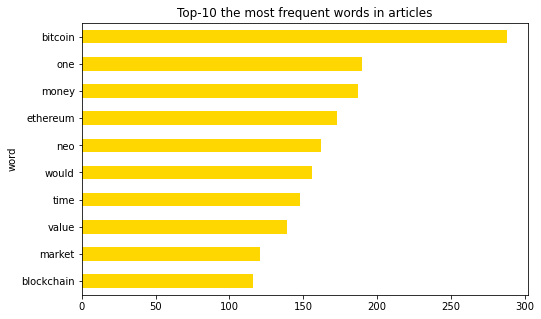

In [20]:
count_df.toPandas()[:10].sort_values(by = 'count').plot.barh(x = 'word', y = 'count', color = 'gold', figsize=(8,5), legend = False, title = 'Top-10 the most frequent words in articles')

<AxesSubplot:title={'center':'Top-20 the most frequent words in articles'}, ylabel='word'>

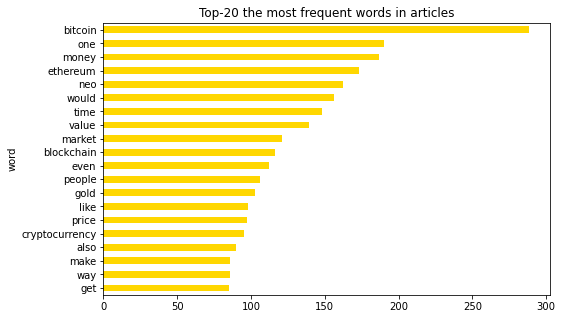

In [21]:
count_df.toPandas()[:20].sort_values(by = 'count').plot.barh(x = 'word', y = 'count', color = 'gold', figsize=(8,5), legend = False, title = 'Top-20 the most frequent words in articles')

<AxesSubplot:title={'center':'Top-20 the rarest words in articles'}, ylabel='word'>

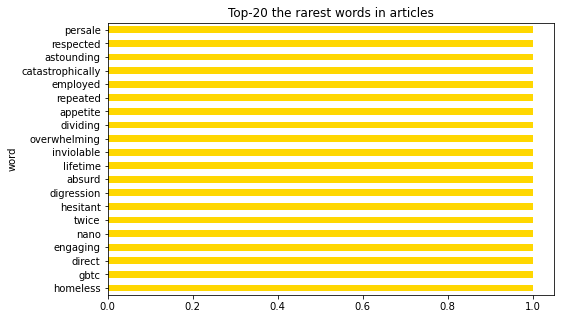

In [22]:
count_df.toPandas().sort_values(by = 'count', ascending = True)[:20].plot.barh(x = 'word', y = 'count', color = 'gold', figsize=(8,5), legend = False, title = 'Top-20 the rarest words in articles')

In [23]:
count_df.toPandas().sort_values(by = 'count', ascending = True)[:20]

,count,word
5429,1,homeless
3687,1,gbtc
3686,1,direct
3685,1,engaging
3684,1,nano
3683,1,twice
3682,1,hesitant
3681,1,digression
3688,1,absurd
3680,1,lifetime


### Word Cloud

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import pandas as pd
import numpy as np

In [25]:
background_image = np.array(Image.open('bitcoin.jpg'))

In [26]:
frequencies = count_df.toPandas().set_index('word').T.to_dict('records')

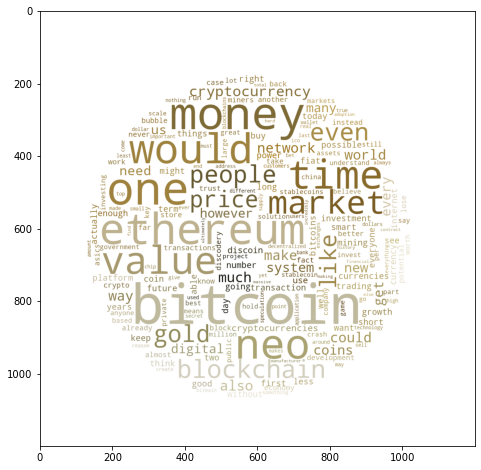

In [27]:
wordcloud = WordCloud(background_color = 'white', max_words = 200, mask = background_image)

wordcloud.generate_from_frequencies(dict(*frequencies))

img_colors = ImageColorGenerator(background_image)
wordcloud.recolor(color_func = img_colors)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud)

## TF-IDF

In [28]:
from pyspark.mllib.feature import HashingTF, IDF

In [29]:
hashingTF = HashingTF()
tf = hashingTF.transform(sc.textFile(r'C:\Users\kkerb\OneDrive\Рабочий стол\HW2\Articles').map(lambda line: line.split(' ')))

In [30]:
tf.cache()
idf = IDF(minDocFreq=1).fit(tf)
tfidf = idf.transform(tf)

In [31]:
tfidf.take(1)

[SparseVector(1048576, {0: 0.0, 1475: 0.8578, 4942: 1.7047, 5346: 3.6159, 13281: 0.6061, 15069: 0.0, 15361: 0.4013, 18461: 1.7047, 20493: 1.7047, 23751: 1.7047, 27852: 1.7047, 29135: 0.6061, 30758: 2.5986, 33648: 2.0232, 36647: 3.0348, 47335: 1.7047, 49830: 0.7885, 50594: 3.8978, 54471: 0.6061, 54767: 8.4859, 56094: 1.7047, 56778: 1.0116, 58234: 0.7885, 59645: 1.0116, 59798: 1.0116, 61560: 1.7047, 61871: 1.7047, 62073: 1.5769, 62486: 1.2993, 65172: 1.7047, 65540: 1.2993, 68131: 0.3185, 70359: 1.6054, 70882: 0.0, 71032: 1.2993, 71153: 1.5923, 72722: 1.2993, 73202: 1.7047, 75527: 1.7047, 78764: 1.7047, 79172: 0.0, 83025: 1.5769, 85574: 1.0116, 86662: 1.2993, 88206: 1.7047, 92596: 0.452, 93813: 5.1142, 94614: 13.9411, 96747: 0.6061, 101774: 1.2993, 105609: 2.5986, 105953: 0.3185, 108957: 1.7047, 111399: 1.8184, 112307: 1.0116, 115593: 0.0, 117554: 3.4095, 121302: 1.2993, 123974: 0.8578, 129147: 0.0, 129151: 1.7047, 130000: 0.904, 134178: 0.6061, 139511: 0.0, 140274: 1.2993, 141112: 1.7047

In [32]:
tfidf.count()

10